In [4]:
import h5py

# Open the v7.3+ .mat file using h5py

# This opens the .mat file (which is an HDF5 file under the hood) in read mode ('r').
# The with statement ensures the file is properly closed after use, even if an error occurs
with h5py.File(r'C:\Users\congy\Desktop\Gritton_Lab\Katamine_Data\622\downsampled_LFP.mat', 'r') as f:
    # Print all top-level keys (variable names)
    print(list(f.keys()))
    
    # [:] reads all data from that variable into memory as a NumPy array.
    data = f['data_combine_Low_downsample'][:]  # Read and load into memory
    print(data.shape)



['data_combine_Low_downsample']
(4968346, 32)


In [5]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def create_notch_filter(fs, f0, Q):
    """
    Create a digital notch filter to remove 60Hz noise
    
    Parameters:
    fs : float
        Sampling frequency in Hz
    f0 : float
        Notch frequency (default 60Hz)
    Q : float
        Quality factor (higher Q = narrower notch)
        
    Returns:
    b, a : ndarray
        Numerator and denominator polynomials of the IIR filter
    """
    # Normalize notch frequency by Nyquist frequency
    w0 = f0/(fs/2)
    
    # Create the notch filter
    b, a = signal.iirnotch(w0, Q)
    
    return b, a



SystemExit: 0

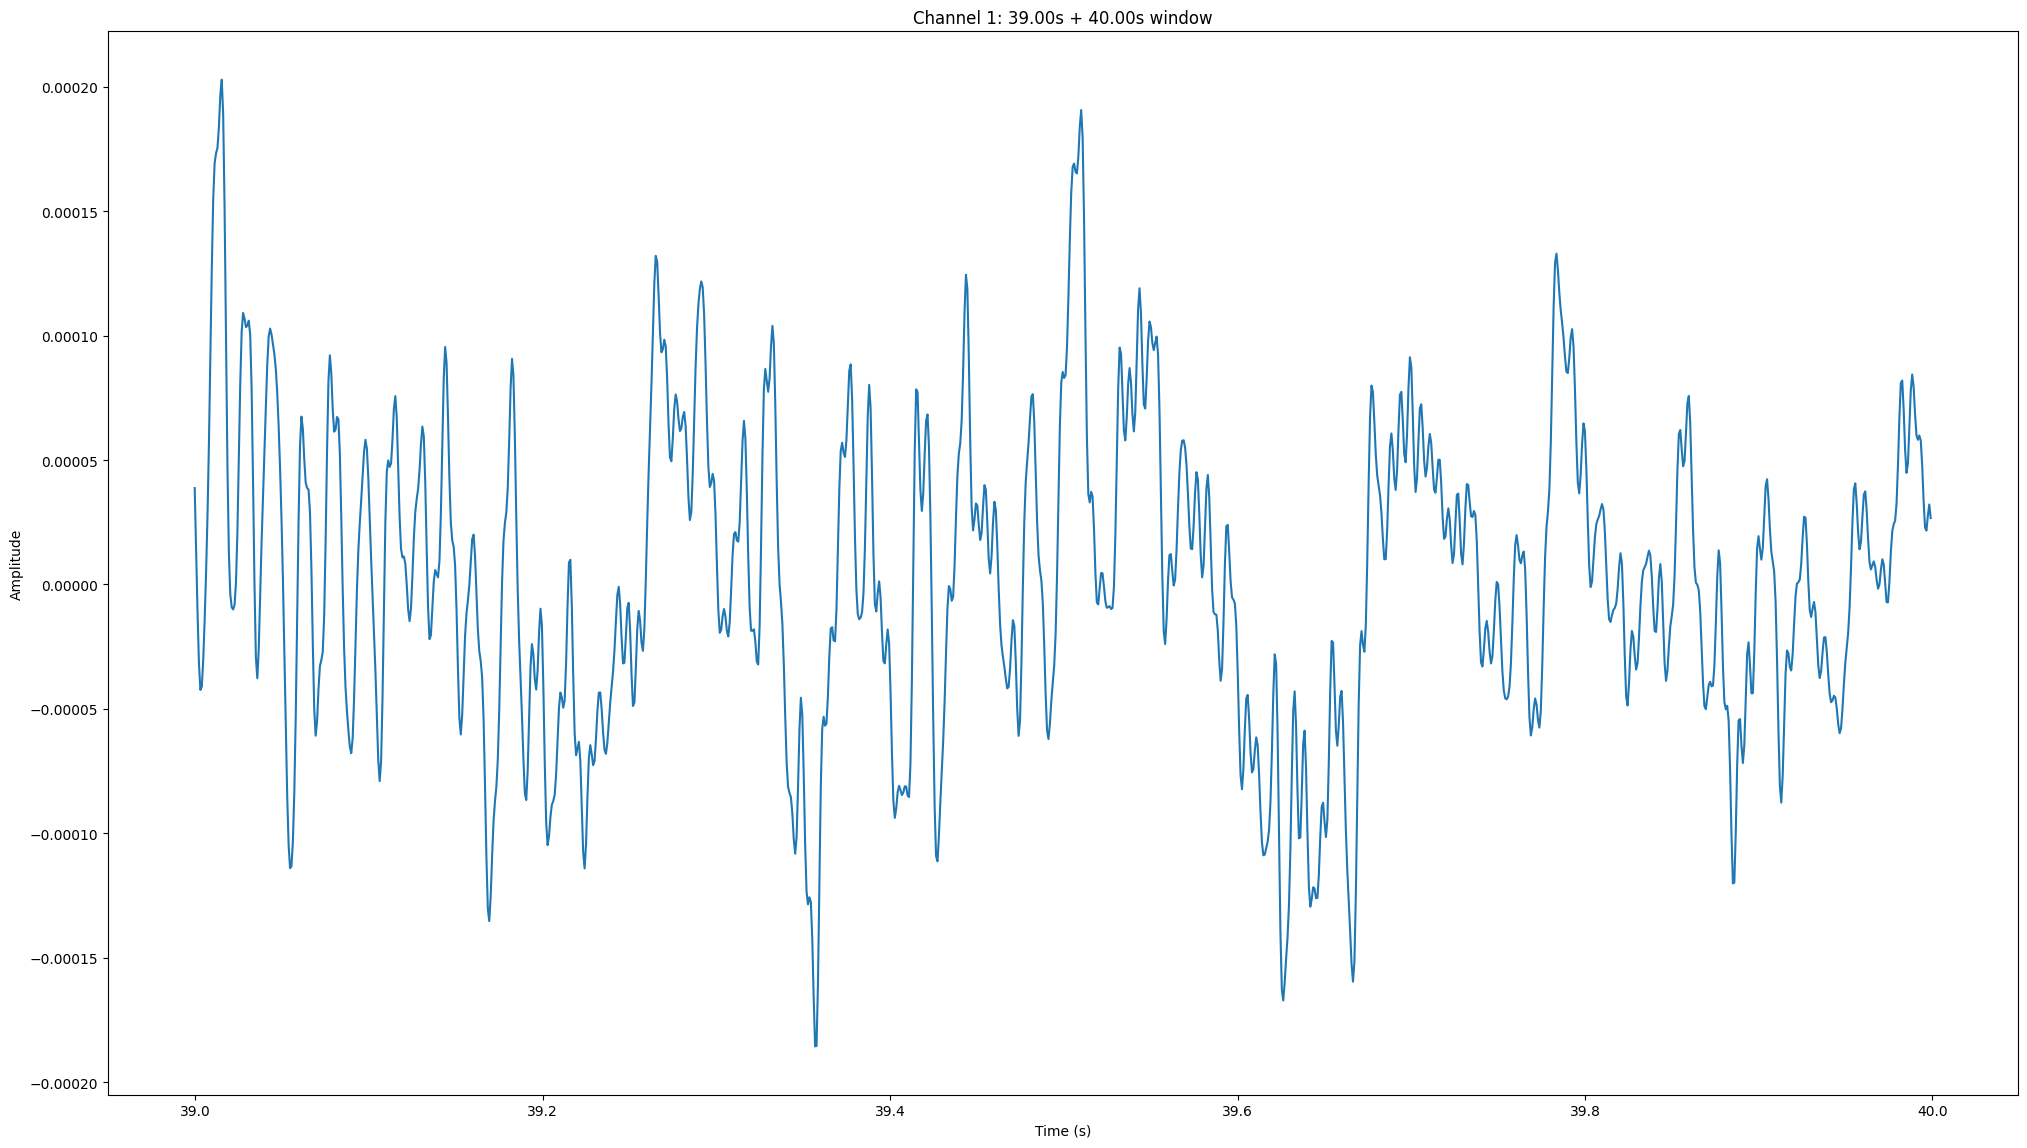

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PyQt5 import QtWidgets, QtCore
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas


# This defines a new class DataPlotter that inherits from QWidget, which is a basic GUI window in PyQt5
class DataPlotter(QtWidgets.QWidget):
    def __init__(self, data, sampling_rate, b, a):
        # super().__init__() calls the constructor (__init__) of the parent class, which is QtWidgets.QWidget in this case.
        # DataPlotter is a subclass of QtWidgets.QWidget, which means it inherits GUI behavior from QWidget.
        super().__init__()

        self.data = data
        self.sampling_rate = sampling_rate
        self.window_size_sec = 1  # default window size in seconds
        
        # This calls a method that sets up the graphical interface (buttons, canvas, inputs, etc.)
        self.initUI()

    def initUI(self):
        layout = QtWidgets.QVBoxLayout(self)

        # Matplotlib Figure
        self.figure, self.ax = plt.subplots()
        self.canvas = FigureCanvas(self.figure)
        layout.addWidget(self.canvas)

        # Channel selection
        # QtWidgets.QComboBox() creates a dropdown (combo box) for selecting the channel to plot.
        self.channel_selector = QtWidgets.QComboBox()
        # self.data.shape[1] gives the number of channels in your data (columns of the data array).
        for i in range(self.data.shape[1]):
            self.channel_selector.addItem(f"Channel {i+1}")
        self.channel_selector.currentIndexChanged.connect(self.update_plot)
        layout.addWidget(self.channel_selector)

        # Start Time and Window Size Input
        time_layout = QtWidgets.QHBoxLayout()

        self.start_time_input = QtWidgets.QLineEdit()
        self.start_time_input.setPlaceholderText("Start time (s)")
        time_layout.addWidget(QtWidgets.QLabel("Start Time (s):"))
        time_layout.addWidget(self.start_time_input)

        self.window_size_input = QtWidgets.QLineEdit()
        self.window_size_input.setPlaceholderText("Infinity (s)")
        time_layout.addWidget(QtWidgets.QLabel("Stop Time (s):"))
        time_layout.addWidget(self.window_size_input)

        layout.addLayout(time_layout)
        
        
        # Slider for moving through time
        self.slider = QtWidgets.QSlider(QtCore.Qt.Horizontal)
        self.slider.setMinimum(0)
        self.slider.setMaximum(self.data.shape[0] - 1)
        self.slider.setValue(0)
        self.slider.valueChanged.connect(self.slide_plot)
        layout.addWidget(self.slider)
        

        # Plot Button
        self.plot_button = QtWidgets.QPushButton("Plot")
        self.plot_button.clicked.connect(self.update_plot)
        layout.addWidget(self.plot_button)

        self.setLayout(layout)


        
        # Set default values
        self.start_time_input.setText('0')
        self.window_size_input.setText(str(self.window_size_sec))

        self.update_plot()

    def update_plot(self):
        """Update plot based on start time and window size entered by user."""
        try:
            start_time = float(self.start_time_input.text())
            window_size_sec = float(self.window_size_input.text())
        except ValueError:
            print("Invalid input! Please enter valid numbers for start time and window size.")
            return

        # Convert times to indices
        start_idx = int(start_time * self.sampling_rate)
        #stop_idx = int((start_time + window_size_sec) * self.sampling_rate)
        stop_idx = int((window_size_sec) * self.sampling_rate)

        if start_idx < 0 or stop_idx > self.data.shape[0] or start_idx >= stop_idx:
            print("Invalid time range. Please check your start time and window size.")
            return

        channel_idx = self.channel_selector.currentIndex()

        # Clear and replot
        self.ax.clear()
        time_axis = np.arange(start_idx, stop_idx) / self.sampling_rate
        
        # Then filter your data before plotting
        filtered_data = signal.lfilter(b, a, self.data[start_idx:stop_idx, channel_idx])

        # Plot the filtered data
        self.ax.plot(time_axis, filtered_data)
        
        #self.ax.plot(time_axis, self.data[start_idx:stop_idx, channel_idx])
        
        

        self.ax.set_xlabel('Time (s)')
        self.ax.set_ylabel('Amplitude')
        self.ax.set_title(f'Channel {channel_idx + 1}: {start_time:.2f}s + {window_size_sec:.2f}s window')
        self.canvas.draw()
        
    



    def slide_plot(self):
        start_idx = self.slider.value()

        # Get text safely from the input box
        input_text = self.window_size_input.text()

        try:
            window_size_sec = float(input_text) if input_text else self.window_size_sec
        except ValueError:
            QtWidgets.QMessageBox.warning(self, "Input Error", "Please enter a valid number for window size.")
            return

        window_size_samples = int(window_size_sec * self.sampling_rate)
        end_idx = start_idx + window_size_samples
        channel_idx = self.channel_selector.currentIndex()

        # Ensure end index doesn't go out of bounds
        end_idx = min(end_idx, self.data.shape[0])

        self.ax.clear()
        time_axis = np.arange(start_idx, end_idx) / self.sampling_rate
        self.ax.plot(time_axis, self.data[start_idx:end_idx, channel_idx])

        self.ax.set_xlabel('Time (s)')
        self.ax.set_ylabel('Amplitude')
        self.ax.set_title(f'Channel {channel_idx + 1}')
        self.canvas.draw()


if __name__ == '__main__':
    import sys


    sampling_rate = 24414.0625 / 20  # 1220.703125 Hz
    b, a = create_notch_filter(sampling_rate, f0=60.0, Q=30)

    app = QtWidgets.QApplication(sys.argv)
    window = DataPlotter(data, sampling_rate, b, a)
    window.setWindowTitle('Data Plotter')
    window.resize(800, 600)
    window.show()
    sys.exit(app.exec_())
